In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter

### Preprocessing Data

In [2]:
df_1= pd.read_excel("formPHB.xlsx", sheet_name='Sheet1',parse_dates=False) #+PHB
df_2= pd.read_excel("formPHB.xlsx", sheet_name='Sheet2',parse_dates=False) #-PHB
df_1=df_1.dropna()
df_2=df_2.dropna()

In [3]:
# Function to convert duration to total seconds
def convert_to_seconds(time_obj):
    if pd.isna(time_obj):
        return None
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1e6

In [4]:

# Apply the function to the Duration column
df_1['Seconds'] = df_1['Duration'].apply(convert_to_seconds)
df_2['Seconds'] = df_2['Duration'].apply(convert_to_seconds)



In [5]:
def add_day_seconds(df, time_col):
    seconds_in_day = 24*60*60
    df['Seconds'] = df[time_col].apply(convert_to_seconds)
    df['Seconds_Cumulative'] = df['Seconds']
    
    # If the current row's time is smaller than the previous one, it means we've crossed into a new day
    df.loc[df['Seconds'].diff() < 0, 'Seconds_Cumulative'] += seconds_in_day

    # If there are still remaining resets, add additional days
    while (df['Seconds_Cumulative'].diff() < 0).any():
        df.loc[df['Seconds_Cumulative'].diff() < 0, 'Seconds_Cumulative'] += seconds_in_day

    return df

df_1 = add_day_seconds(df_1, 'Duration')
df_2 = add_day_seconds(df_2, 'Duration')



### Generate Figure 2c

In [6]:
#function to compute OD based on the polynomial fitting
def calculate_real_od(internal_od):
    real_od = 0.7793*internal_od*internal_od  + 2.4831*internal_od + 0.0347
    return real_od


df_1["Real OD"]=calculate_real_od(df_1["Internal OD"])
df_2["Real OD"]=calculate_real_od(df_2["Internal OD"])

In [7]:
# Apply Savitzky-Golay filter to smooth the data
window_length = 61  # Window length for the filter, should be odd
polyorder = 5  # Order of polynomial to use in the filter
df_1["real_od_smooth"] = savgol_filter(df_1["Real OD"], window_length, polyorder)
df_2["real_od_smooth"] = savgol_filter(df_2["Real OD"], window_length, polyorder)

Text(0.5, 0, 'Time (Days)')

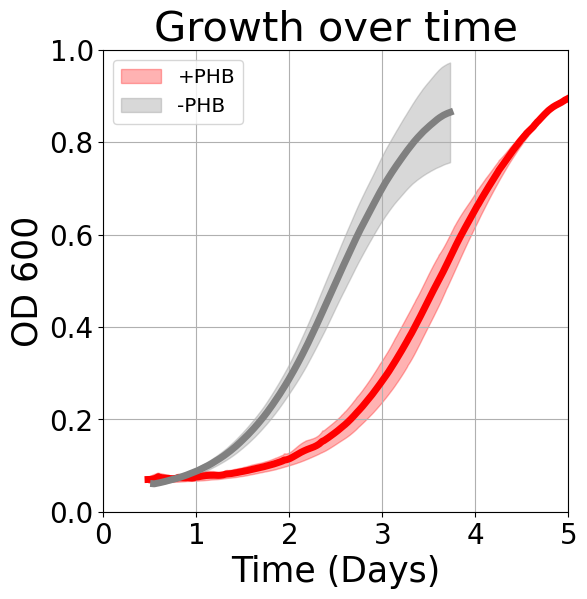

In [8]:

f = plt.figure(figsize=(6, 6))

# Extracting the two segments of the data 
y1 = df_1["real_od_smooth"][2660:3540].to_numpy()
y2 = df_1["real_od_smooth"][4660:5540].to_numpy()
#y2=df2["real_od_smooth"][3900:4575].to_numpy()

# Ensuring both y1 and y2 are of the same length for calculations
min_length = min(len(y2),len(y1))
y1 = y1[:min_length]

y2 = y2[:min_length]

# Calculate the average and standard deviation
average1 = (y1 +y2) / 2
std_dev1 = np.sqrt(((y1 - average1) ** 2  + (y2 - average1) ** 2) / 2)


# Time axis for the plot
x1 = (df_1["Seconds_Cumulative"][2660:2660 + min_length]) / (3600 * 24) - 18

# Plotting the average curve
sns.lineplot(x=x1, y=average1, color='red', linewidth=5)

# Adding the standard deviation shadow
plt.fill_between(x1, average1 - std_dev1, average1 + std_dev1, color='red', alpha=0.3, label='+PHB')


# Extracting the two segments of data you mentioned

y3 = df_2["real_od_smooth"][610:1070].to_numpy()
y4 = df_2["real_od_smooth"][1160:1700].to_numpy()

# Ensuring both y1 and y2 are of the same length for calculations
min_length = min(len(y3),  len(y4))
y4 = y4[:min_length]
y3 = y3[:min_length]

# Calculate the average and standard deviation
average2 = (y4 +y3) / 2
std_dev2 = np.sqrt(( +(y4 - average2) ** 2 + (y3 - average2) ** 2) / 2)

# Time axis for the plot
x2 = (df_1["Seconds_Cumulative"][2660:2660 + min_length]-1550000) / (3600 * 24) 

# Plotting the average curve
sns.lineplot(x=x2, y=average2, color='grey', linewidth=5)

# Adding the standard deviation shadow
plt.fill_between(x2, average2 - std_dev2, average2 + std_dev2, color='grey', alpha=0.3, label='-PHB')
plt.ylabel('OD 600', fontsize=25)
plt.title('Growth over time', fontsize=30)
plt.legend(fontsize='x-large', title_fontsize='40')
plt.grid()
# Customizing the plot
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 1)
plt.xlim(0, 5)
plt.xlabel('Time (Days)', fontsize=25)

In [9]:
#saving
f.savefig("1.pdf", bbox_inches='tight')

### Generate Supplemental Figure 1

In [34]:
df_3 = pd.read_csv("Auto 05012023.txt", sep="	",thousands=',',skiprows=42)

Text(0.5, 1.0, 'Standard of PHB')

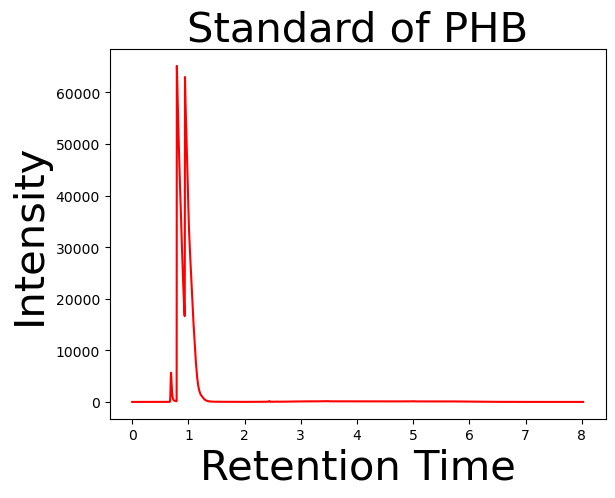

In [35]:
# Extract the retention time and intensity columns from the DataFrame
retention_times = df_3['Time (min)']
intensities = df_3['Value (pA)']


f=plt.figure()
# Extract the retention time and intensity columns from the DataFrame
retention_times = df_3['Time (min)']
intensities = df_3['Value (pA)']

# Plot the chromatogram
plt.plot(retention_times, intensities, color="red")

# Set the axis labels and title
plt.xlabel('Retention Time', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
plt.title('Standard of PHB', fontsize=30)

In [29]:
#saving
f.savefig("2_a.pdf", bbox_inches='tight')

In [32]:
df_4 = pd.read_csv("Auto 27122022.txt", sep="	",thousands=',',skiprows=42)

Text(0.5, 1.0, 'Standard of PHB')

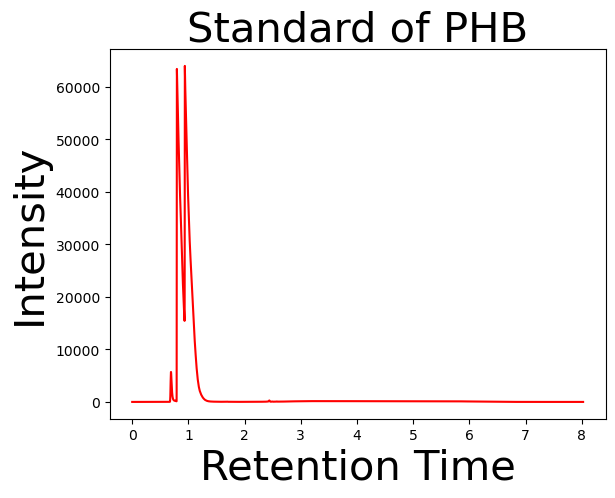

In [33]:
# Extract the retention time and intensity columns from the DataFrame
retention_times = df_4['Time (min)']
intensities = df_4['Value (pA)']


f=plt.figure()
# Extract the retention time and intensity columns from the DataFrame
retention_times = df_4['Time (min)']
intensities = df_4['Value (pA)']

# Plot the chromatogram
plt.plot(retention_times, intensities, color="red")

# Set the axis labels and title
plt.xlabel('Retention Time', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
plt.title('Standard of PHB', fontsize=30)

In [ ]:
#saving
f.savefig("2_a.pdf", bbox_inches='tight')

### Generate Figure S-Unknown 

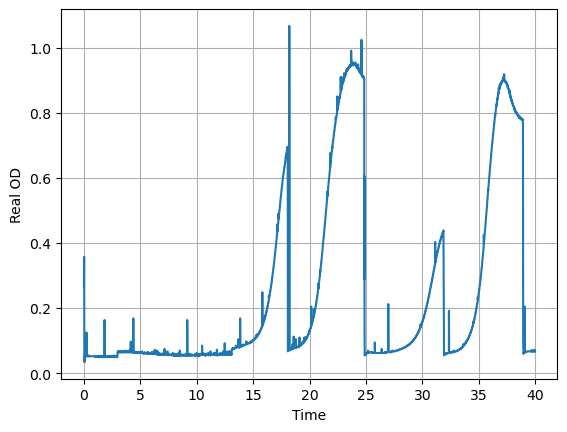

In [10]:

f2 = plt.figure()
plt.plot(df_1["Seconds_Cumulative"]/(3600*24),df_1["Real OD"])
plt.grid()
plt.xlabel("Time")
plt.ylabel("Real OD")
f2.savefig("2.pdf", bbox_inches='tight')

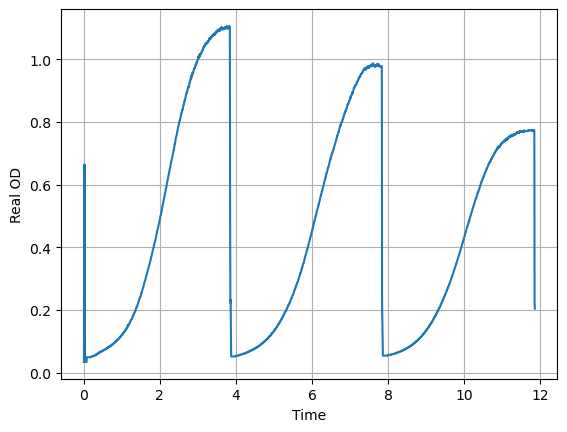

In [11]:
f2 = plt.figure()
plt.plot(df_2["Seconds_Cumulative"]/(3600*24),df_2["Real OD"])
plt.grid()
plt.xlabel("Time")
plt.ylabel("Real OD")
f2.savefig("3.pdf", bbox_inches='tight')

In [13]:
df_1

,Duration,Internal OD,Seconds,Seconds_Cumulative,Real OD,real_od_smooth
1,00:10:00.008000,0.090,600.008,600.008,0.264491,0.368204
2,00:20:00.017000,0.125,1200.017,1200.017,0.357264,0.300174
3,00:30:00.025000,0.125,1800.025,1800.025,0.357264,0.242437
4,00:40:00.033000,0.125,2400.033,2400.033,0.357264,0.193935
5,00:50:00.166000,0.001,3000.166,3000.166,0.037184,0.153674
...,...,...,...,...,...,...
5769,1900-02-08 22:22:10.399000,0.015,80530.399,3450130.399,0.072122,0.067821
5770,1900-02-08 22:32:10.409000,0.013,81130.409,3450730.409,0.067112,0.067969
5771,1900-02-08 22:42:10.421000,0.013,81730.421,3451330.421,0.067112,0.068134
5772,1900-02-08 22:52:10.433000,0.014,82330.433,3451930.433,0.069616,0.068317
